Моделирование движения заряженной частицы в электрическом, магнитном и электромагнитном поле

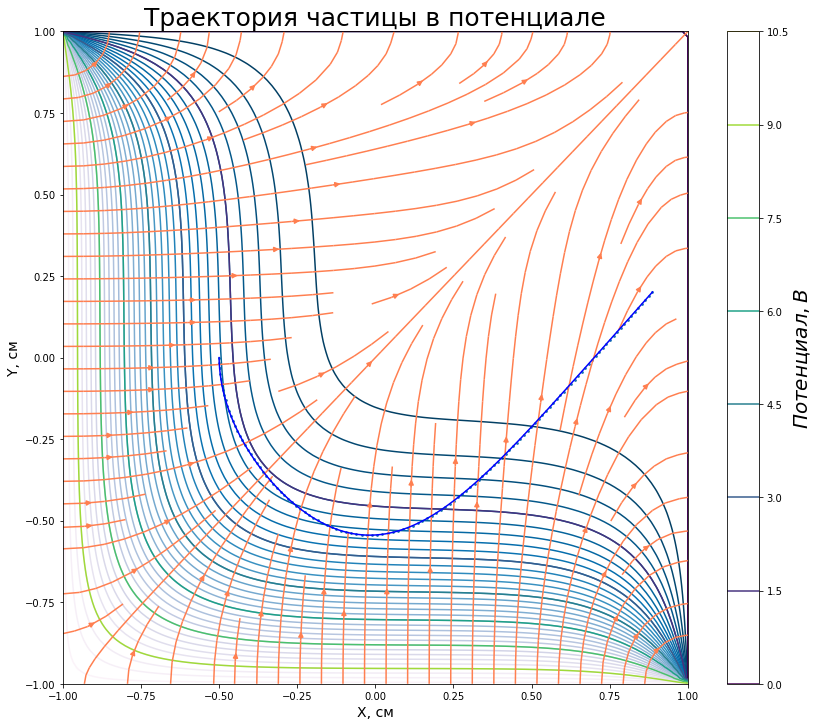

In [2]:
# Электрическое поле
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint
from scipy import interpolate
from matplotlib import ticker, cm


# создание сетки
N = 120
x, dx = np.linspace(-1, 1, N + 1, retstep=True)
y, dy = np.linspace(-1, 1, N + 1, retstep=True)
xx, yy = np.meshgrid(x , y)

# параметры моделирования
Number_of_Iteration = 1000
Omega = 1
phi = np.zeros((x.size, y.size))
ro = np.zeros((x.size, y.size))
ro[50:-50, 50:-50] = 0
phi[:, 0] = 10
phi[:, -1] = 0
phi[0, :] = 10
phi[-1, :] = 0

#расчет потенциала
for i in range(Number_of_Iteration):
    phi[1:-1, 1:-1] = (1 - Omega) * phi[1:-1, 1:-1] + 0.25 * Omega * (phi[:-2, 1:-1] + phi[2:,
    1:-1] + phi[1:-1, 2:] + phi[1:-1, :-2] + dx * dy * ro[1:-1, 1:-1])

#расчет напряженности в узлах и между ними (при помощи интерполяции)
Ey, Ex = np.gradient(phi, dx, dy)
Ex = - Ex
Ey = - Ey
Ex_int = interpolate.interp2d(x, y, Ex)
Ey_int = interpolate.interp2d(x, y, Ey)

#начальные скорости и координаты заряженной частицы
steps = 120
velocity = np.zeros(2)
velocity[0] = 0
velocity[1] = -2
amplitude_E = 1
start_motion = np.zeros((steps, 2))
start_motion[0, 0] = -0.5
start_motion[0, 1] = 0


for i in range(1,steps):
    t = dx / (velocity @ velocity + 0.01)**0.5
    velocity[0] += (amplitude_E * Ex_int(start_motion[i - 1, 0], start_motion[i - 1, 1])) * t
    velocity[1] += (amplitude_E * Ey_int(start_motion[i - 1, 0], start_motion[i - 1, 1])) * t
    start_motion[i, 0] = start_motion[i - 1, 0] + velocity[0] * t
    start_motion[i, 1] = start_motion[i - 1, 1] + velocity[1] * t

    
fig, ax = plt.subplots(1, 1, figsize = (14, 12))
ax.contour(xx, yy, phi, 35, cmap=cm.PuBu_r)
im=plt.contour(xx,yy,phi)
cbar = fig.colorbar(im)
cbar.set_label("$Потенциал, В$", fontsize = 20)

# траектория частицы
ax.scatter(start_motion[:, 0], start_motion[:, 1], s = 3)
tck2, u2 = interpolate.splprep( [start_motion[:, 0], start_motion[:, 1]], s = 0 )
xnew, ynew = interpolate.splev( np.linspace( 0, 1, 800), tck2,der = 0)
ax.plot(xnew , ynew, '-b', label = r'Траектория частицы')

# линии электр поля
#ax.set_aspect('equal', adjustable = 'box')
ax.set_title("Траектория частицы в потенциале", fontsize = 25)
ax.streamplot(x, y, Ex, Ey, color='coral')

ax.set_xlabel("X, см", fontsize=14)
ax.set_ylabel("Y, см", fontsize=14)
plt.show()

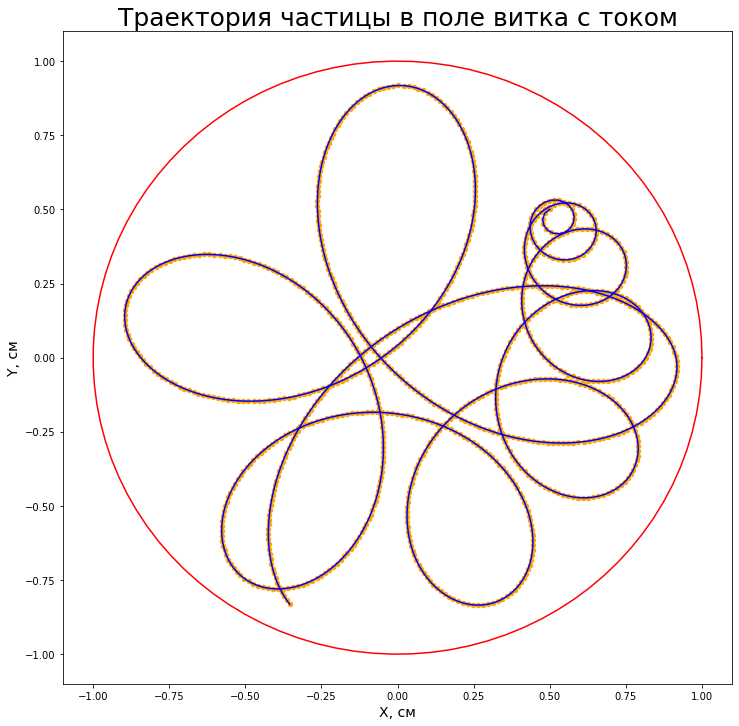

In [3]:
# Магнитное поле
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint
from scipy import interpolate
from matplotlib import ticker, cm
from matplotlib.pyplot import (figure)

def sub_vect(v, w):
    """Функция для получения разности двух векторов."""
    return [vi - wi for vi, wi in zip(v, w)]

def module(v):
    """Функция для получения длины вектора."""
    return (np.sqrt(v @ v)) # @ - умножение матриц

#создание сетки
N = 120
x, dx = np.linspace(-1, 1, N + 1, retstep=True)
y, dy = np.linspace(-1, 1, N + 1, retstep=True)
xx, yy = np.meshgrid(x , y)

# задаём кольцо с током
b = 100
amplitude_length = 2
segment = np.linspace(0, 2 * np.pi, b)
x_ring = 1 * np.cos(segment)
y_ring = 1 * np.sin(segment)

# k - вектор касательной к окружности (вектор тока в каждой конкретной точке кольца)
vector_I_x_y = list(zip(y_ring * amplitude_length, - x_ring * amplitude_length))

# приводим координаты кольца
r0 = list(zip(x_ring, y_ring))
r0 = np.array(r0)
dr = np.zeros((b, 2))

#начальные скорости и координаты
steps = 1000
velocity = np.zeros(2)
velocity[0] = -7
velocity[1] = 0
start_motion = np.zeros((steps, 2))
start_motion[0, 0] = 0.5
start_motion[0, 1] = 0.5
amplitude_B = 1


for i in range(1, steps):
    B = np.zeros(3)
    
    # вычисляем магнитное поле в точке как сумму магнитных полей, создаваемых каждым угловым сегментом кольца
    for j in range(0, b, 1):
        dr[j] = sub_vect(start_motion[i - 1], r0[j])  # в этом внутреннем цикле итерируемся по сегментам
        B[2] += np.cross(vector_I_x_y[j], dr[j]) / (module(dr[j]))**3  # по формуле 5.6 вычисляем магнитное поле кусочка
                                                                       # и суммируем их по J
    
    acceleration = np.cross(velocity, B)
    t = dx / (velocity @ velocity + 0.01)**0.5
    velocity[0] += (amplitude_B * acceleration[0]) * t  # изменение скорости равно ускорение на время. Что такое амплитуда? 
    velocity[1] += (amplitude_B * acceleration[1]) * t
    start_motion[i, 0] = start_motion[i - 1, 0] + velocity[0] * t
    start_motion[i, 1] = start_motion[i - 1, 1] + velocity[1] * t

    
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax.scatter(start_motion[:, 0], start_motion[:, 1], c='orange', s = 20)
ax.plot(x_ring, y_ring, color = 'red', label = r'Кольцо')
tck2, u2 = interpolate.splprep( [start_motion[:, 0], start_motion[:, 1]], s = 0 )
xnew, ynew = interpolate.splev( np.linspace( 0, 1, 800), tck2, der = 0)
ax.plot(xnew , ynew, '-b', label = r'Траектория частицы')

ax.set_title("Траектория частицы в поле витка с током", fontsize = 25)
ax.set_xlabel("X, см", fontsize=14)
#ax2.set_title("Траектория частицы в потенциале", fontsize = 25)
ax.set_ylabel("Y, см", fontsize=14)
plt.show()

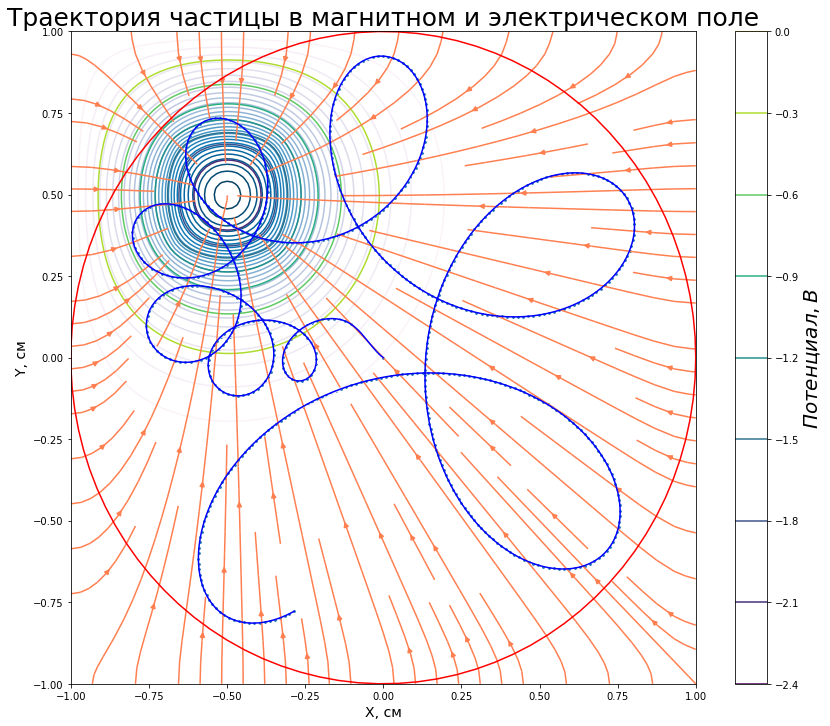

In [4]:
# Электромагнитное поле
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint
from scipy import interpolate
from matplotlib import ticker, cm


def sub_vect(v, w):
    return [vi - wi for vi, wi in zip(v, w)]

def module(v):
    return (np.sqrt(v @ v))

#создание сетки
N = 120
x, dx = np.linspace(-1, 1, N + 1, retstep=True)
y, dy = np.linspace(-1, 1, N + 1, retstep=True)
xx, yy = np.meshgrid(x , y)

# Электрическое поле - распределение заряда, потенциал на границах
Number_of_Iteration = 1000
Omega = 1
phi = np.zeros((x.size, y.size))
ro = np.zeros((x.size, y.size))
ro[80:-20, 20:-80] = -100
phi[:, 0] = 0
phi[:, -1] = 0
phi[0, :] = 0
phi[-1, :] = 0

# расчёт потенциала
for i in range(Number_of_Iteration):
    phi[1:-1, 1:-1] = (1 - Omega) * phi[1:-1, 1:-1] + 0.25 * Omega * (phi[:-2, 1:-1] + phi[2:,
    1:-1] + phi[1:-1, 2:] + phi[1:-1, :-2] + dx * dy * ro[1:-1, 1:-1])

#расчет напряженности в узлах и между ними (при помощи интерполяции)
Ey, Ex = np.gradient(phi, dx, dy)
Ex = - Ex
Ey = - Ey
Ex_int = interpolate.interp2d(x, y, Ex)
Ey_int = interpolate.interp2d(x, y, Ey)

# Магнитное поле
b = 100
amplitude_length = 2
segment = np.linspace(0, 2 * np.pi, b)
x_ring = 1 * np.cos(segment)
y_ring = 1 * np.sin(segment)

# k - вектор касательной к окружности (вектор тока в каждой конкретной точке
#кольца)
vector_I_x_y = list(zip(y_ring * amplitude_length, - x_ring * amplitude_length))
r0 = list(zip(x_ring, y_ring))
r0 = np.array(r0)
dr = np.zeros((b, 2))

#начальные скорости и координаты
steps = 700
velocity = np.zeros(2)
velocity[0] = 0
velocity[1] = 0
amplitude_E = 10
start_motion = np.zeros((steps, 2))
start_motion[0, 0] = 0
start_motion[0, 1] = 0
amplitude_B = 0.1

# Итеративный расчёт сил э-м поля и изменения координат
for i in range(1,steps):
    B = np.zeros(3)
    for j in range(0, b, 1):
        dr[j] = sub_vect(start_motion[i - 1], r0[j])
        B[2] += np.cross(vector_I_x_y[j], dr[j]) / (module(dr[j]))**3
    acceleration = np.cross(velocity, B)
    t = dx / (velocity @ velocity + 0.01)**0.5
    
    velocity[0] += (amplitude_E * Ex_int(start_motion[i - 1, 0], start_motion[i - 1, 1]) +  # электрическая составляющая
                    amplitude_B * acceleration[0]) * t                                      # магнитная составляющая
    velocity[1] += (amplitude_E * Ey_int(start_motion[i - 1, 0], start_motion[i - 1, 1]) +
                    amplitude_B * acceleration[1]) * t
    start_motion[i, 0] = start_motion[i - 1, 0] + velocity[0] * t
    start_motion[i, 1] = start_motion[i - 1, 1] + velocity[1] * t

fig, ax = plt.subplots(1, 1, figsize = (14, 12))
ax.contour(xx, yy, phi, 35, cmap=cm.PuBu_r)
im=plt.contour(xx,yy,phi)
cbar = fig.colorbar(im)
cbar.set_label("$Потенциал, В$", fontsize = 20)

ax.scatter(start_motion[:, 0], start_motion[:, 1], s = 3)
ax.plot(x_ring, y_ring, color = 'red', label = r'Кольцо')
tck2, u2 = interpolate.splprep( [start_motion[:, 0], start_motion[:, 1]], s = 0 )
xnew, ynew = interpolate.splev( np.linspace( 0, 1, 800), tck2,der = 0)
ax.plot(xnew , ynew, '-b', label = r'Траектория частицы')

ax.set_title("Траектория частицы в магнитном и электрическом поле", fontsize = 25)
ax.streamplot(x, y, Ex, Ey, color='coral')
ax.set_xlabel("X, см", fontsize=14)
ax.set_ylabel("Y, см", fontsize=14)
plt.show()